# Changelog
- Changed uncov to uconv, but removed the dropout in the last layer
- Corrected sanity check of predicted validation data (changed from ids_train to ids_valid)
- Used correct mask (from original train_df) for threshold tuning (inserted y_valid_ori)

# About
Since I am new to learning from image segmentation and kaggle in general I want to share my noteook.
I saw it is similar to others as it uses the U-net approach. I want to share it anyway because:

- As said, the field is new to me so I am open to suggestions.
- It visualizes some of the steps, e.g. scaling, to learn if the methods do what I expect which might be useful to others (I call them sanity checks).
- Added stratification by the amount of salt contained in the image.
- Added augmentation by flipping the images along the y axes (thanks to the forum for clarification).
- Added dropout to the model which seems to improve performance.

In [1]:
import gc
from pathlib import Path

import numpy as np
import pandas as pd

from keras.preprocessing.image import load_img
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.transform import resize

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

/home/jun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from contextlib import contextmanager
import time

@contextmanager
def timer(title):
    start = time.time()
    yield
    print('{}...  Done in {:.2f}'.format(title, time.time()-start))

# Params and helpers

In [3]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [4]:
data_dir = Path("data")
train_csv = str(data_dir / "train.csv")
depths_csv = str(data_dir / "depths.csv")

In [5]:
with timer('load dataset...'):
    train_df = pd.read_csv(train_csv, index_col='id', usecols=[0])
    depth_df = pd.read_csv(depths_csv, index_col='id')
    train_df['z'] = depth_df.loc[train_df.index, 'z']
    test_df = depth_df[~depth_df.index.isin(train_df.index)]
    print('num of train samples: {}, num of test samples: {}'.format(len(train_df), len(test_df)))


num of train samples: 4000, num of test samples: 18000
load dataset......  Done in 0.40


# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [6]:
train_imgs_dir = data_dir / "train/images"
train_masks_dir = data_dir / "train/masks"

In [7]:
train_df["image"] = [np.array(load_img(str(train_imgs_dir / "{}.png".format(idx)), grayscale=True)) / 255 for idx in tqdm(train_df.index)]

100%|██████████| 4000/4000 [00:25<00:00, 156.53it/s]


In [8]:
train_df["mask"] = [np.array(load_img(str(train_masks_dir / "{}.png".format(idx)), grayscale=True)) / 255 for idx in tqdm(train_df.index)]

100%|██████████| 4000/4000 [00:09<00:00, 419.41it/s]


# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [9]:
train_df["coverage"] = train_df['mask'].map(np.mean)
train_df["coverage_class"] = train_df['coverage'].apply(lambda x: np.ceil(x * 10)).astype(np.int32)

Plot salt coverage...  Done in 0.33


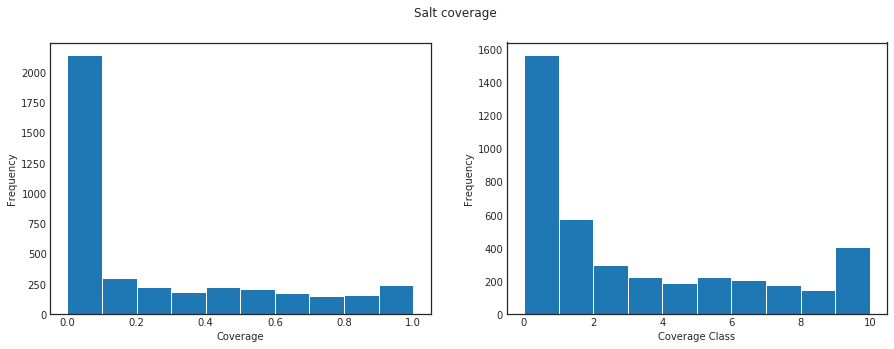

In [10]:
with timer('Plot salt coverage'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    train_df['coverage'].plot.hist(ax=axes[0])
    train_df['coverage_class'].plot.hist(ax=axes[1])
    plt.suptitle("Salt coverage")
    axes[0].set_xlabel("Coverage")
    axes[1].set_xlabel("Coverage Class")

Text(0,0.5,'Coverage Class')

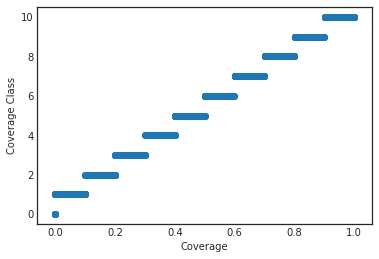

In [11]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage Class")

# Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data.

Text(0.5,1,'Depth distribution')

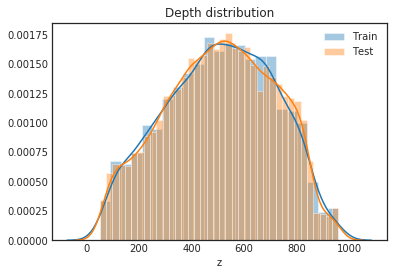

In [12]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Show some example images

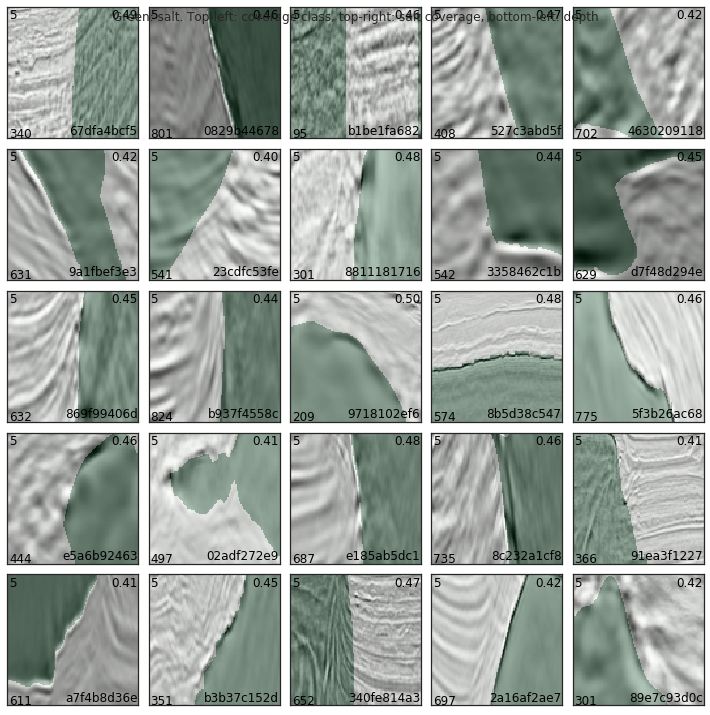

In [14]:
max_images = 25
grid_width = 5
grid_height = int(np.ceil(max_images / grid_width))
color = 'black'
fontsize = 12
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
coverage_mask = train_df['coverage_class'] == 5
for i, idx in enumerate(np.random.choice(train_df[coverage_mask].index, max_images, replace=False)):
    img = train_df.loc[idx, 'image']
    mask = train_df.loc[idx, 'mask']
    ax = axs[i//grid_width, i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, cmap="Greens", alpha=0.3)
    ax.text(1, img_size_ori-1, train_df.loc[idx, 'z'], color='black', fontsize=12)
    ax.text(img_size_ori-1, 1, '{:.2f}'.format(train_df.loc[idx, 'coverage']), color='black', ha='right', va='top', fontsize=12)
    ax.text(1, 1, train_df.loc[idx, 'coverage_class'], color='black', ha='left', va='top', fontsize=12)
    ax.text(img_size_ori-1, img_size_ori-1, idx, color=color, fontsize=fontsize, ha='right', va='bottom') 
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.tight_layout()

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [15]:
ids_train, ids_valid = train_test_split(train_df.index.values, test_size=0.2, stratify=train_df['coverage_class'],
                                        random_state=43)



In [16]:
with timer("UpSample"):
    x_train = np.stack(train_df.loc[ids_train, 'image'].map(upsample), axis=0)[..., np.newaxis]
    y_train = np.stack(train_df.loc[ids_train, 'mask'].map(upsample), axis=0)[..., np.newaxis]

    x_valid = np.stack(train_df.loc[ids_valid, 'image'].map(upsample), axis=0)[..., np.newaxis]
    y_valid = np.stack(train_df.loc[ids_valid, 'mask'].map(upsample), axis=0)[..., np.newaxis]

print('x_train: {}, y_train: {},  x_valid: {}, y_valid: {}'.format(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape))

UpSample...  Done in 13.93
x_train: (3200, 128, 128, 1), y_train: (3200, 128, 128, 1),  x_valid: (800, 128, 128, 1), y_valid: (800, 128, 128, 1)


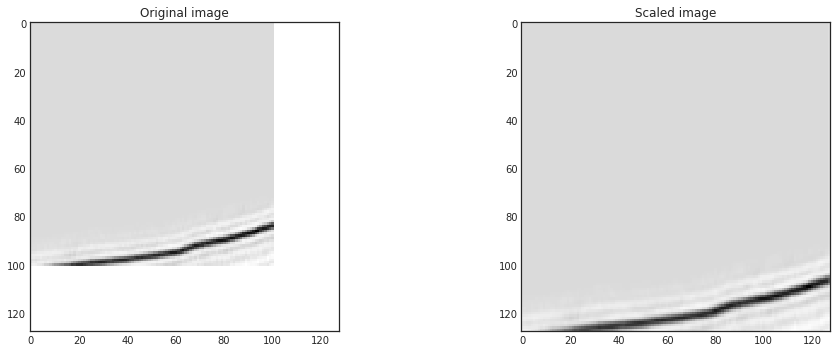

In [17]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=np.float32)
tmp_img[:img_size_ori, :img_size_ori] = train_df.loc[ids_train[20], 'image']
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[20].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")
plt.tight_layout()

# Build model

In [18]:
ACTIVATION = "relu"
USE_BN = True
USE_RESIDUAL = False
DROP_RATE = 0.5
USE_UPSAMPLING = True


from keras.layers import Conv2D, BatchNormalization, Dropout, Concatenate
from keras.layers import MaxPool2D, UpSampling2D, Conv2DTranspose, Input
from keras.models import Model
import keras.backend as K

# input: n_channels, (mxm)
# output: n_channels, (m x m)
def conv_block(inputs, n_channels, dropout=0.0):
    n = Conv2D(n_channels, kernel_size=3, activation=ACTIVATION, padding="same")(inputs)
    n = BatchNormalization()(n) if USE_BN else n
    n = Dropout(dropout)(n) if dropout else n
    n = Conv2D(n_channels, kernel_size=3, activation=ACTIVATION, padding="same")(n)
    n = BatchNormalization()(n) if USE_BN else n
    return n
    # Concatenate()([inputs, n]) if USE_RESIDUAL else n

def up_block(inputs, conv_outputs, conv_channels):
    x = inputs
    
    for conv_ch, conv_x in zip(conv_channels[::-1], conv_outputs[::-1]):
        if USE_UPSAMPLING:
            x = UpSampling2D()(x)
            x = Conv2D(conv_ch, kernel_size=2, activation=ACTIVATION, padding="same")(x)
        else:
            x = Conv2DTranspose(conv_ch, kernel_size=3, strides=2, activation=ACTIVATION, padding="same")(x)
        x = Concatenate()([conv_x, x])
        x = conv_block(x, conv_ch)
    return x
    

def UNet():
    inputs = Input(shape=(img_size_target, img_size_target, 1))
    x = inputs
    
    # 128x128x1
    # 64x64x16
    # 32x32x32
    # 16x16x64
    # 8x8x128
    # 4x4x256
    conv_channels = [16, 32, 64, 128, 256]
    conv_outputs = []
    for n_channels in conv_channels:
        x = conv_block(x, n_channels)
        conv_outputs.append(x)
        x = MaxPool2D()(x)
    # middle: 4x4x512
    x = conv_block(x, 512, dropout=DROP_RATE)
    
    # 128x128x16
    x = up_block(x, conv_outputs, conv_channels)
    
    # last layer: 128x128x16
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)
    
    

In [19]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2.0 * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2.0 * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [20]:
with timer('Build model'):
    model = UNet()
    model.compile(loss=bce_dice_loss, optimizer='adam', metrics=['accuracy'])
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

# Data augmentation

In [21]:
with timer("Flip left-right"):
    x_train = np.concatenate([x_train, x_train[:,:,::-1,:]], axis=0)
    y_train = np.concatenate([y_train, y_train[:,:,::-1,:]], axis=0)

Flip left-right...  Done in 1.07


In [23]:
whos

Variable              Type           Data/Info
----------------------------------------------
ACTIVATION            str            relu
BatchNormalization    type           <class 'keras.layers.norm<...>tion.BatchNormalization'>
Concatenate           type           <class 'keras.layers.merge.Concatenate'>
Conv2D                type           <class 'keras.layers.convolutional.Conv2D'>
Conv2DTranspose       type           <class 'keras.layers.conv<...>utional.Conv2DTranspose'>
DROP_RATE             float          0.5
Dropout               type           <class 'keras.layers.core.Dropout'>
Input                 function       <function Input at 0x7f2973552ae8>
K                     module         <module 'keras.backend' f<...>ras/backend/__init__.py'>
MaxPool2D             type           <class 'keras.layers.pooling.MaxPooling2D'>
Model                 type           <class 'keras.engine.training.Model'>
Path                  type           <class 'pathlib.Path'>
UNet                  fu

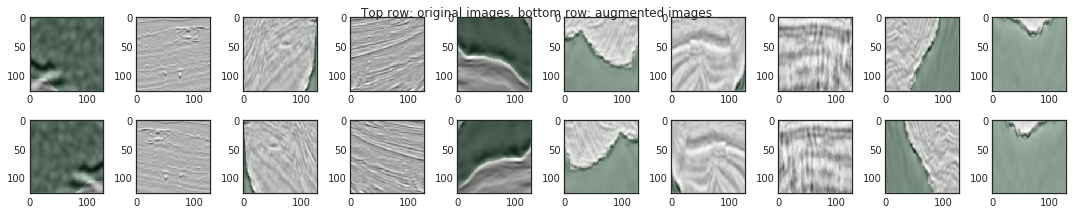

In [24]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")
plt.tight_layout()

# Training

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [26]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

if not Path("./keras.model").exists():
    with timer("Training"):
        history = model.fit(x_train, y_train,
                            validation_data=[x_valid, y_valid], 
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 800 samples
Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[32,16,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_27/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/batch_normalization_21/cond/Merge_grad/cond_grad"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_21/cond/Merge, conv2d_27/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training/Adam/gradients/batch_normalization_22/cond/batchnorm/add_1_grad/Shape/_1389 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2770_...grad/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_27/convolution', defined at:
  File "/home/jun/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jun/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jun/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jun/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/jun/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jun/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jun/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jun/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jun/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jun/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jun/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-7b90dc383767>", line 2, in <module>
    model = UNet()
  File "<ipython-input-18-da2582d9a99f>", line 58, in UNet
    x = up_block(x, conv_outputs, conv_channels)
  File "<ipython-input-18-da2582d9a99f>", line 34, in up_block
    x = conv_block(x, conv_ch)
  File "<ipython-input-18-da2582d9a99f>", line 19, in conv_block
    n = Conv2D(n_channels, kernel_size=3, activation=ACTIVATION, padding="same")(n)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/jun/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3341, in conv2d
    data_format=tf_data_format)
  File "/home/jun/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "/home/jun/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/home/jun/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/home/jun/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/home/jun/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/jun/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jun/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/jun/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,16,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_27/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/batch_normalization_21/cond/Merge_grad/cond_grad"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_21/cond/Merge, conv2d_27/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training/Adam/gradients/batch_normalization_22/cond/batchnorm/add_1_grad/Shape/_1389 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2770_...grad/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [ ]:
model = load_model("./keras.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [ ]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.stack(train_df.loc[ids_valid, 'mask'], axis=0)

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx, 'image']
    mask = train_df.loc[idx, 'mask']
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm(thresholds)])

In [ ]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

In [ ]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

In [ ]:
# max_images = 60
# grid_width = 15
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(ids_valid[:max_images]):
#     img = train_df.loc[idx].images
#     mask = train_df.loc[idx].masks
#     pred = preds_valid[i]
#     ax = axs[int(i / grid_width), i % grid_width]
#     ax.imshow(img, cmap="Greys")
#     ax.imshow(mask, alpha=0.3, cmap="Greens")
#     ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
#     ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
#     ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
#     ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
# plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Submission
Load, predict and submit the test image predictions.

In [ ]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [ ]:
x_test = np.array([upsample(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
with timer("Predict"):
    preds_test = model.predict(x_test)

In [ ]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission2.csv')

In [ ]:
sub.shape